<a href="https://colab.research.google.com/github/Mattmack1/Stock-Strategy-Analysis/blob/main/StockStrategyAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectives
### *   Get trading data, check and plot the data
### *   Calculate technical indicators
### *   Build signal-based strategies and perform backtesting
### *   Conduct strategy optimization and benchmarking
### *   Evaluate strategy performance








Must pip install bt for the imports to work.

In [ ]:
#!pip install bt
import pandas as pd
import numpy as np
import bt
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

### Simple function to plot the results of an individual strategy.

In [ ]:
def show_backtest_results(backtest, stockName):
  benchmark = buy_and_hold(ticker, name='buy_and_hold')
  res = bt.run(backtest, benchmark)
  res.plot(title=backtest)
  plt.show()

### Simple Moving Average strategy, input any rolling average and start/end date.

In [ ]:
def SMA_strategy(ticker, rolling_average, strategyName, start = '2018-4-1', end='2021-5-6'):
  #Get data and calculate the SMA
  price_data = bt.get(ticker, start=start, end=end)
  sma = price_data.rolling(rolling_average).mean()
  #Define the SMA strategy
  bt_strategy = bt.Strategy(strategyName,
                            [bt.algos.SelectWhere(price_data > sma),
                            bt.algos.WeighEqually(),
                            bt.algos.Rebalance()])
  
  return bt.Backtest(bt_strategy, price_data)

### Exponential Moving Average Crossover Strategy, when the shorter moving average is above the longer moving average, there is a buy signal.

Include display=true in order to visualize the strategy.

In [ ]:
def EMA_strategy(ticker, short_period, long_period, strategyName = 'Strategy', start = '2018-4-1', end='2021-5-6', display=False):
  #Get data and calculate the EMA short and EMA long
  price_data = bt.get(ticker, start=start, end=end)
  price_data.columns = ['Close']

  EMA_short = talib.EMA(price_data['Close'], timeperiod=short_period).to_frame()
  EMA_long = talib.EMA(price_data['Close'], timeperiod=long_period).to_frame()  
  #Define the Signal
  signal = EMA_long.copy()
  signal[EMA_long.isnull()] = 0
  signal[EMA_short > EMA_long] = 1
  signal[EMA_short < EMA_long] = -1
  signal.columns = ['Close']

  if display == True:
    combined_df = bt.merge(signal, price_data, EMA_short, EMA_long)
    combined_df.columns = ['Signal', 'Price', 'EMA_short', 'EMA_long']
    combined_df.plot(secondary_y = ['Signal'], figsize=(10,10))

  #Define the EMA strategy
  bt_strategy = bt.Strategy(strategyName, 
                            [bt.algos.WeighTarget(signal),
                             bt.algos.Rebalance()])
  
  return bt.Backtest(bt_strategy, price_data)

### RSI Mean Reversion. An asset is usually considered overbought when the RSI (Relative Strength Indicator) is above 70% and oversold when it is below 30%.

In [ ]:
def RSI_mean_reversion_strategy(ticker, strategyName, start = '2018-4-1', end='2021-5-6', display = False):
  price_data = bt.get(ticker, start=start, end=end)
  price_data.columns = ['Close']

  stock_rsi = talib.RSI(price_data['Close']).to_frame()

  signal = stock_rsi.copy()
  signal[stock_rsi.isnull()] = 0

  #construct our signal
  signal[stock_rsi < 30] = 1
  signal[stock_rsi > 70] = -1
  signal[(stock_rsi <= 70) & (stock_rsi >= 30)] = 0
  signal.columns = ['Close']

  if display == True:
    combined_df = bt.merge(signal, price_data)
    combined_df.columns = ['Signal', 'Price']

    combined_df.plot(secondary_y = ['Signal'])
    stock_rsi.plot()
    plt.title('RSI')

  bt_strategy = bt.Strategy(strategyName,
                            [bt.algos.WeighTarget(signal),
                             bt.algos.Rebalance()])
  
  return bt.Backtest(bt_strategy, price_data)

### MACD (Moving Average Convergence Divergence)

### MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. 

In [ ]:
def MACD_strategy(ticker, strategyName, start = '2018-4-1', end='2021-5-6', display = False):
  price_data = bt.get(ticker, start=start, end=end)
  price_data.columns = ['Close']

  macd_pd = pd.DataFrame()

  macd_pd['macd'], macd_pd['macdsignal'], macd_pd['macdhist'] = talib.MACD(price_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

  indicator = np.where((macd_pd.macd > macd_pd.macdsignal), 1, -1)

  signal = pd.DataFrame(data=indicator, index=macd_pd.index)

  signal.columns = ['Close']

  if display == True:
    fig, ax1 = plt.subplots(1,1, sharex=True) 
    macd_pd.macd.plot(ax = ax1, label='macd')
    macd_pd.macdsignal.plot(ax = ax1, label='signal')
    macd_pd.macdhist.plot(ax = ax1, label='hist')
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)

  bt_strategy = bt.Strategy(strategyName,
                            [bt.algos.WeighTarget(signal),
                            bt.algos.Rebalance()])
  
  return bt.Backtest(bt_strategy, price_data)

### Benchmark buy and hold to test most strategies against.

In [ ]:
def buy_and_hold(ticker, name, start = '2018-4-1', end='2021-5-6'):
  #Get data
  price_data = bt.get(ticker, start=start, end=end)

  #Define the buy and hold strategy
  bt_strategy = bt.Strategy(name,
                            [bt.algos.RunOnce(),
                             bt.algos.SelectAll(),
                             bt.algos.WeighEqually(),
                             bt.algos.Rebalance()])
  
  return bt.Backtest(bt_strategy, price_data)

In [ ]:

def get_strategy_stats(strategy_results):
  resinfo = strategy_results.stats
  print('Daily Returns: %.4f'% resinfo.loc['daily_mean'])
  print('Monthly Returns: %.4f'% resinfo.loc['monthly_mean'])
  print('Yearly Returns: %.4f'% resinfo.loc['yearly_mean'])
  print('Compound annual growth rate: %.4f'% resinfo.loc['cagr'])
  print()
  max_drawdown = resinfo.loc['max_drawdown']
  print("Max drawdown: %.2f"% max_drawdown)
  avg_drawdown = resinfo.loc['avg_drawdown']
  print("Avg drawdown: %.2f"% avg_drawdown)
  avg_drawdown_days = resinfo.loc['avg_drawdown_days']
  print("Avg drawdown days: %.2f"% avg_drawdown_days)
  print()
  #Calmar = CAGR/Max Drawdown
  #The higher the Calmar ratio, the better a strategy performed on a risk-adjusted basis
  #A Calmar ratio larger than 3 is considered excellent.
  cagr = resinfo.loc['cagr']
  calmar = cagr/max_drawdown * (-1)
  print('Calmar Ratio: %.2f'% calmar)
  print()
  #The bigger the sharpe ratio the better.
  print('Sharpe Ratio Daily: %.2f'% resinfo.loc['daily_sharpe'])
  print('Sharpe Ratio Monthly: %.2f'% resinfo.loc['monthly_sharpe'])
  print('Sharpe Ratio Yearly: %.2f'% resinfo.loc['yearly_sharpe'])
  print()
  #The bigger the sortino ratio the better.
  print('Sortino Ratio Daily: %.2f'% resinfo.loc['daily_sortino'])
  print('Sortino Ratio Monthly: %.2f'% resinfo.loc['monthly_sortino'])
  print('Sortino Ratio Yearly: %.2f'% resinfo.loc['yearly_sortino'])

## Example of testing and comparing different SMA strategies.

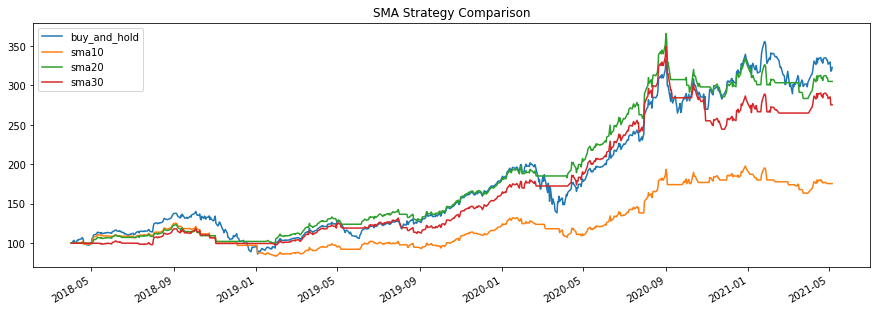

In [ ]:
ticker = 'aapl'

sma10 = SMA_strategy(ticker,
                     rolling_average=10,
                     strategyName='sma10')

sma20 = SMA_strategy(ticker,
                     rolling_average=20,
                     strategyName='sma20')

sma30 = SMA_strategy(ticker,
                     rolling_average=30,
                     strategyName='sma30')
benchmark = buy_and_hold(ticker, name='buy_and_hold')
bt_results = bt.run(benchmark, sma10, sma20, sma30)
bt_results.plot(title="SMA Strategy Comparison")

### It looks like the SMA 20 is the best performing strategy aside from buy and hold.

In [ ]:
looback_returns = bt_results.display_lookback_returns()
print(looback_returns)

      buy_and_hold   sma10   sma20   sma30
mtd         -1.31%   0.00%   0.00%  -2.75%
3m          -5.13%  -2.54%  -0.66%   1.23%
6m           9.47%  -4.10%   2.46%   8.06%
ytd         -2.08%  -8.61%  -6.15%  -1.01%
1y          73.96%  53.57%  43.77%  41.29%
3y          42.72%  17.50%  42.79%  40.21%
5y            nan%    nan%    nan%    nan%
10y           nan%    nan%    nan%    nan%
incep       45.99%  19.94%  43.36%  38.71%


### Use SMA 20 and get performance metrics on the strategy.
Sharpe Ratio is (Return of Portfolio - Risk-Free Rate) divided by the standard deviation of the portfolio's excess return.

The Sortino ratio is a variation of the Sharpe ratio that differentiates harmful volatility from total overall volatility by using the asset's standard deviation of negative portfolio returns—downside deviation—instead of the total standard deviation of portfolio returns. (Taken from Investopedia).

In [ ]:
sma20 = SMA_strategy(ticker,
                     rolling_average=20,
                     strategyName='sma20')
bt_results = bt.run(sma20)
get_strategy_stats(bt_results)

Daily Returns: 0.3849
Monthly Returns: 0.4000
Yearly Returns: 0.5016
Compound annual growth rate: 0.4336

Max drawdown: -0.22
Avg drawdown: -0.03
Avg drawdown days: 19.02

Calmar Ratio: 1.93

Sharpe Ratio Daily: 1.73
Sharpe Ratio Monthly: 1.52
Sharpe Ratio Yearly: 1.03

Sortino Ratio Daily: 2.91
Sortino Ratio Monthly: 3.65
Sortino Ratio Yearly: 14.13


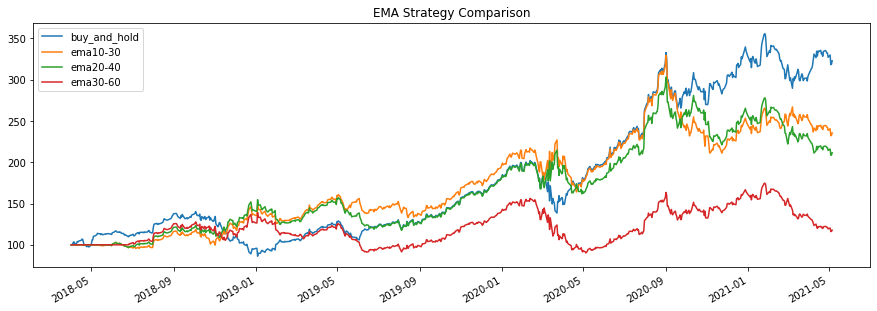

In [ ]:
ticker = 'aapl'

ema1030 = EMA_strategy(ticker,
                     short_period=10,
                     long_period=30,
                     strategyName='ema10-30')

ema2040 = EMA_strategy(ticker,
                     short_period=20,
                     long_period=40,
                     strategyName='ema20-40')

ema3060 = EMA_strategy(ticker,
                     short_period=30,
                     long_period=60,
                     strategyName='ema30-60')
benchmark = buy_and_hold(ticker, name='buy_and_hold')
bt_results = bt.run(benchmark, ema1030, ema2040, ema3060)
bt_results.plot(title="EMA Strategy Comparison")

Simple Moving Average comparison between powers of three as the rolling average.

/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


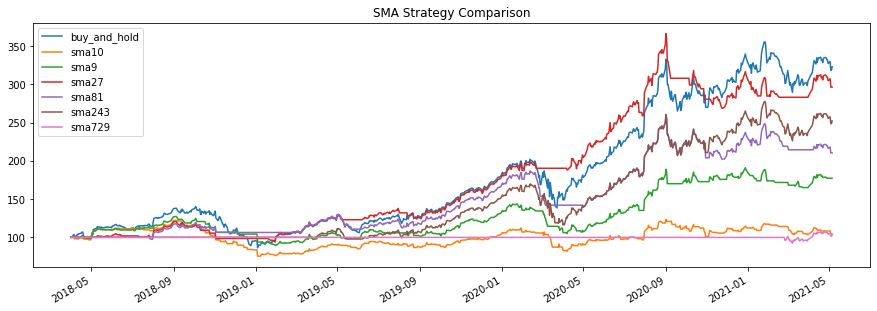

In [ ]:
ticker = 'aapl'

sma3 = SMA_strategy(ticker,
                     rolling_average=3,
                     strategyName='sma10')

sma9 = SMA_strategy(ticker,
                     rolling_average=9,
                     strategyName='sma9')

sma27 = SMA_strategy(ticker,
                     rolling_average=27,
                     strategyName='sma27')

sma81 = SMA_strategy(ticker,
                     rolling_average=81,
                     strategyName='sma81')

sma243 = SMA_strategy(ticker,
                     rolling_average=243,
                     strategyName='sma243')

sma729 = SMA_strategy(ticker,
                     rolling_average=729,
                     strategyName='sma729')





benchmark = buy_and_hold(ticker, name='buy_and_hold')
bt_results = bt.run(benchmark, sma3, sma9, sma27, sma81, sma243, sma729)
bt_results.plot(title="SMA Strategy Comparison")

Random EMA strategies involving using different powers of two as the short/long periods.

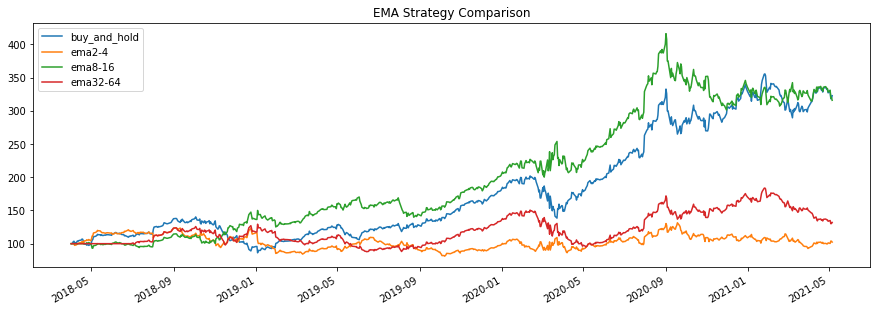

In [ ]:
ticker = 'aapl'

ema24 = EMA_strategy(ticker,
                     short_period=2,
                     long_period=4,
                     strategyName='ema2-4')

ema816 = EMA_strategy(ticker,
                     short_period=8,
                     long_period=16,
                     strategyName='ema8-16')

ema3264 = EMA_strategy(ticker,
                     short_period=32,
                     long_period=64,
                     strategyName='ema32-64')
benchmark = buy_and_hold(ticker, name='buy_and_hold')
bt_results = bt.run(benchmark, ema24, ema816, ema3264)
bt_results.plot(title="EMA Strategy Comparison")

The same thing as above, but with powers of 2 as the shorter period and powers of 3 as the longer period.

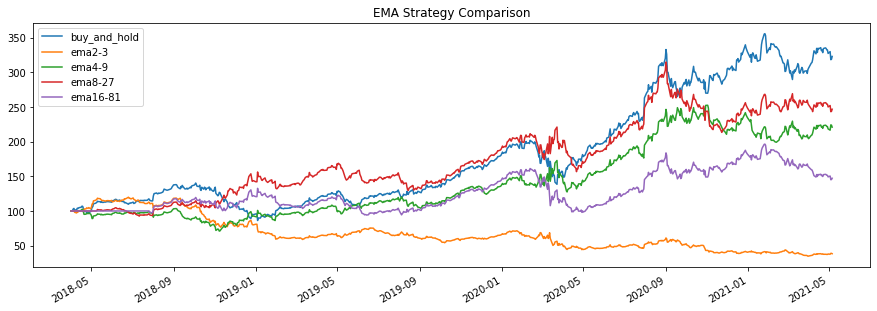

In [ ]:
ticker = 'aapl'

ema23 = EMA_strategy(ticker,
                     short_period=2,
                     long_period=3,
                     strategyName='ema2-3')

ema49 = EMA_strategy(ticker,
                     short_period=4,
                     long_period=9,
                     strategyName='ema4-9')

ema827 = EMA_strategy(ticker,
                     short_period=8,
                     long_period=27,
                     strategyName='ema8-27')

ema1681 = EMA_strategy(ticker,
                     short_period=16,
                     long_period=81,
                     strategyName='ema16-81')


benchmark = buy_and_hold(ticker, name='buy_and_hold')
bt_results = bt.run(benchmark, ema23, ema49, ema827,ema1681 )
bt_results.plot(title="EMA Strategy Comparison")

Lets take a further look at the strategy of the 8-16 EMA.

The blue line is our signal, when it goes to 1 we buy, when it goes to 0 we sell.

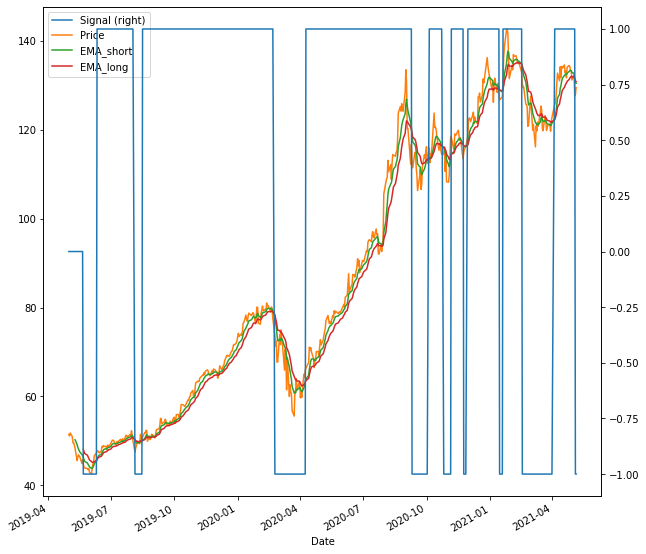

In [ ]:
ema816 = EMA_strategy(ticker,
                     short_period=8,
                     long_period=16,
                     strategyName='ema8-16',
                      start = '2019-05-01',                      
                      display = True)



Compare our results to a buy and hold strategy.

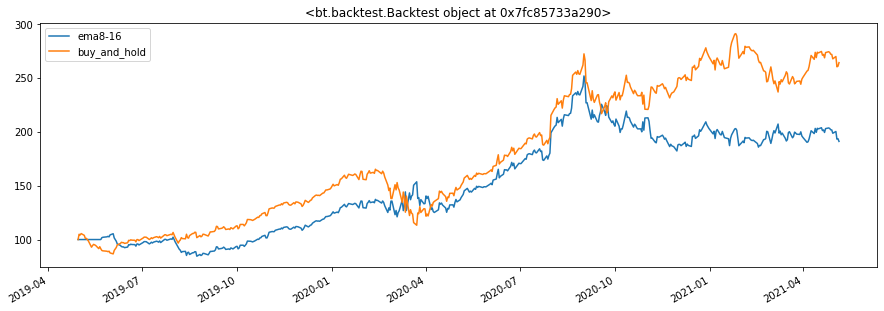

In [ ]:
show_backtest_results(ema816, ticker)

# Use RSI (Relative Strength Indicator) for Mean Reversion

An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%.

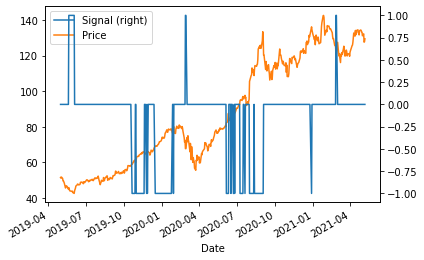

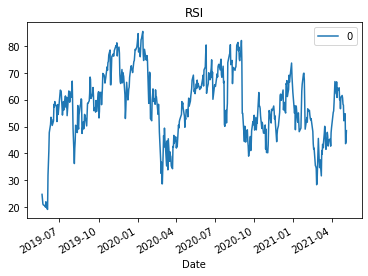

In [ ]:
rsi_aapl = RSI_mean_reversion_strategy(ticker,
                        strategyName='rsi_aapl',
                        start = '2019-05-01',                      
                        display = True)

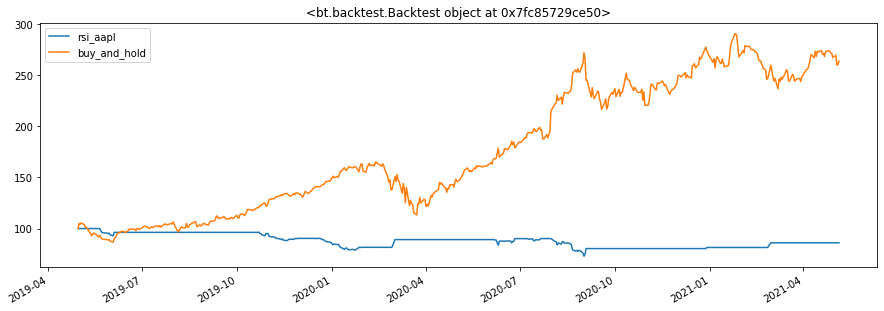

In [ ]:
show_backtest_results(rsi_aapl, ticker)

## Quick MACD test

/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


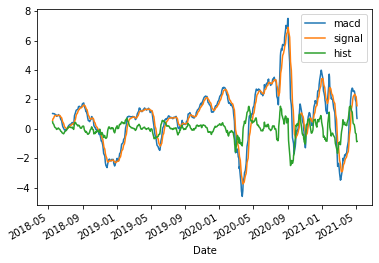

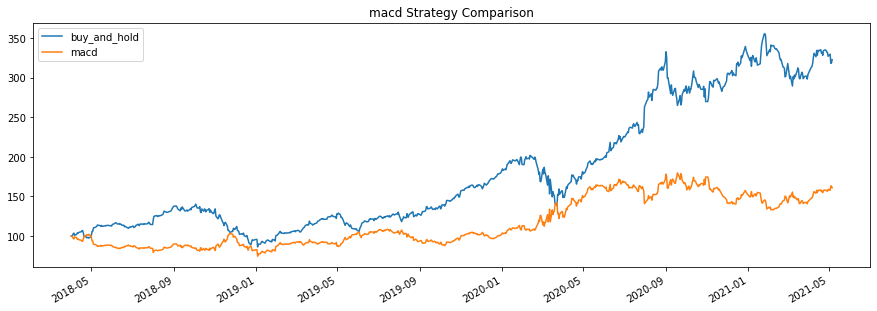

In [ ]:
test = MACD_strategy(ticker,
                     'macd',
                     display = True)
benchmark = buy_and_hold(ticker, name='buy_and_hold')
bt_results = bt.run(benchmark, test)
bt_results.plot(title="macd Strategy Comparison")